In [ ]:
# default_exp models.ranknet

# RankNet
> Learning to Rank for Information Retrieval.

In 2005, Chris Burges et. al. at Microsoft Research introduced a novel approach to create Learning to Rank models. Their approach employed a probabilistic cost function which uses a pair of sample items to learn how to rank them. This function essentially tries to minimize the number of swaps required to correct an incorrect ordering of chosen items. Their paper further explores this approach by implementing this cost function through a neural network, optimized by gradient descent. This network, called “RankNet”, is also tested on some real-world data to show its effectiveness.

As implemented in the paper, the working of RankNet is summarized below.
Training the network
1. A two-layer neural network with one output node is constructed. The output value corresponds to the relevance of that item to the set, and the input layer can have multiple nodes based on the size of the feature vector.
2. Two random samples are selected from the data set and forward propagation is done for both of these samples individually, consequently producing two output values, one for each item.
3. The cost, which is an activation function (eg: sigmoid) of the difference of these two output values, is determined. It is assumed that the first sample is ranked higher than the second one, and the appropriate loss is calculated.
4. This loss is back-propagated into the network to learn the selected example.
5. Steps 2–4 are performed until training is complete (based on number of epochs).

The assumption that is mentioned in step 3 is nothing but the determination of the expected ranks of the two selected items. This rank can be determined by comparing the relevance rating of a particular item with respect to the entire set. Moreover, this relevance rating can be determined by either manually setting the relevance based on some assumptions, or by using human raters to sort the results based on their relevance.


In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.nb_imports import *
from fastcore.test import *

In [1]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
#export
class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        # relevant document score
        s1 = self.model(input_1)
        # irrelevant document score
        s2 = self.model(input_2)
        # subtract scores
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

Example

In [3]:
# generating synthetic data

n_sample = 30000
n_feature = 300

data1 = torch.rand((n_sample, n_feature))
data2 = torch.rand((n_sample, n_feature))

y = np.random.random((n_sample, 1))
y = y > 0.9
y = 1. * y
y = torch.Tensor(y)

In [4]:
rank_model = RankNet(num_feature = n_feature)
optimizer = torch.optim.Adam(rank_model.parameters())
loss_fun = torch.nn.BCELoss()

In [6]:
if torch.cuda.is_available():
    rank_model.cuda()
    loss_fun.cuda()
    data1 = data1.cuda()
    data2 = data2.cuda()
    y = y.cuda()

In [7]:
epoch = 5000

losses = []

for i in range(epoch):
    
    rank_model.zero_grad()
    
    y_pred = rank_model(data1, data2)
    
    loss = loss_fun(y_pred,y)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if i % 500 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6934884786605835
Epoch500, loss : 0.579173743724823
Epoch1000, loss : 0.5610643029212952
Epoch1500, loss : 0.5340487957000732
Epoch2000, loss : 0.5312932729721069
Epoch2500, loss : 0.5039414167404175
Epoch3000, loss : 0.5077282190322876
Epoch3500, loss : 0.48666420578956604
Epoch4000, loss : 0.4898063838481903
Epoch4500, loss : 0.4821886122226715


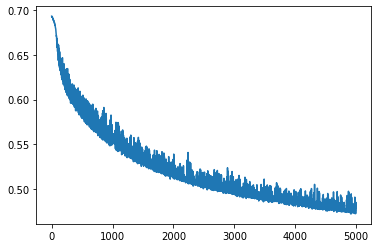

In [8]:
import matplotlib.pyplot as plt

x = list(range(5000))
plt.plot(x, losses);